# Morphological metrics for 3D volumetric ductal structures

This is a companion code of the paper:

*Homological features of airway tree on computed tomography and longitudinal change in lung function in patients with chronic obstructive pulmonary disease*

by Naoya Tanabe, Shizuo Kaji (equal contribution), Susumu Sato, Tomoki Maetani, Yusuke Shiraishi, Tsuyoshi Oguma, Ryo Sakamoto, Motonari Fukui, Shigeo Muro, Toyohiro Hirai

In [ ]:
# execute this cell for setting up the environment
# (it is required only for the first run)
!pip install -U git+https://github.com/shizuo-kaji/CubicalRipser_3dim
!pip install scikit-fmm pynrrd persim skan


## Function definition

In [1]:
import skimage
import matplotlib.pyplot as plt
import nrrd
import numpy as np
import pandas as pd
import os, zipfile, io, re, glob,pprint
import seaborn as sns
import persim
from genericpath import isfile
import networkx as nx
from tqdm.auto import tqdm
import joblib

import ductal_morphology as dm


In [2]:

# batch computation
def process_volume(volume_fn):
    CTID = os.path.splitext(os.path.basename(volume_fn))[0]
    print("\n",CTID)
    volume, header = nrrd.read(volume_fn, index_order='C') # EXAMPLE: we load a volume from an NRRD file; replace this line to load other types of volumes in 3d numpy array
    skeleton_generation,volume_generation,trachea_removed,origin,ac_gens,skeleton_MST = dm.create_generation_volumes(volume,graph_creation="nx",threshold=threshold,min_branch_children=min_branch_children, min_branch_separation=min_branch_separation,remove_trachea=remove_trachea,verbosity=verbosity)
    res={'CTID':CTID,'trachea_z':origin[0],'trachea_y':origin[1],'trachea_x':origin[2]}
    if skip_compute_PH:
        H=None
    else:
        skeleton = (skeleton_generation>0)&(skeleton_generation<=max_gen)
        binarised_volume = (volume_generation>0)&(volume_generation<=max_gen)
        dist_vol = dm.geodesic_distance_transform(skeleton,binarised_volume,origin,outside_fill=OUTSIDE,restrict_to_centerline=False)
        ress,H=dm.compute_PH(dist_vol,CTID,maxdim=maxdim, density=density, min_life=min_life, max_life=max_life, max_birth=max_birth, num_bins=num_bins, PH_dir=PH_dir,OUTSIDE=OUTSIDE,recompute_PH=recompute_PH)
        res.update(ress)
        if save_intermediate:
            for mode in dist_vol.keys():
                nrrd.write(os.path.join(output_dir,f"{CTID}_{mode}_geodesic_dt.nrrd"), dist_vol[mode], index_order='C')
            v = volume_generation.astype(np.int8)
            v[(volume_generation>max_gen)]=0
            v[skeleton_generation>0] = 1 # -skeleton_generation[skeleton_generation>0] # to make skeleton distinguishable, the values are shifted
            v[origin] = 1
            nrrd.write(os.path.join(output_dir,f"{CTID}_volume_gen1-{max_gen}.nrrd"), trachea_removed, index_order='C')
            nrrd.write(os.path.join(output_dir,f"{CTID}_generation.nrrd"), v, index_order='C')
            vmin = volume.min()
            volume[trachea_removed == vmin] = 0 # show removed voxels
            nrrd.write(os.path.join(output_dir,f"{CTID}_removed.nrrd"), volume, index_order='C')
            # plot graph
            # pos = nx.nx_agraph.graphviz_layout(skeleton_MST, prog="dot")
            # nx.draw(skeleton_MST, pos,with_labels = True)
            coords = {v: {i: skeleton_MST.nodes[v]['coords'][i] for i in range(3)} for v in skeleton_MST.nodes}
            nx.set_node_attributes(skeleton_MST,coords,'coords')
            nx.write_gexf(skeleton_MST,os.path.join(output_dir,f"{CTID}_gen1-{max_gen}.gexf"))


    for k,v in ac_gens.items(): #count_cc(skeleton_generation).items():
        res[f'AC_gen{k}']=v
    return(res,H)

# boxplot 
def vboxplot(HS,group_name=None,group=None,density=False,ylabel="#cycles",title="",ax=None):
    tdf = []
    X = np.array(HS)
    if len(X.shape)==1:
        X = X.reshape((-1,1))
    if density:
        X = X / X.sum(axis=1).reshape(-1,1)
    if group is None:
        group = np.zeros(len(X))
    if group_name is None:
        group_name=sorted(list(set(group)))
    for i,c in enumerate(group_name):
        criteria = (group==c)
        for u in X[criteria]:
            for l,v in enumerate(u):
                tdf.append({"bin":l, "group":c, "val":v}) 
    tdf=pd.DataFrame(tdf)
    cmap = plt.get_cmap("tab10")
    sns.set(style="whitegrid")
    if ax is None:
        fig, ax= plt.subplots(1,1,figsize=(15,8))
    sns.boxenplot(x="bin", y="val", hue="group", data=tdf, ax=ax)
    ax.set_ylabel(ylabel)
    #ax.legend(loc=1)
    ax.get_legend().remove()
    ax.set_title(title,y=-0.4,pad=-3)
    plt.tight_layout()

## Main starts here

In [3]:
# configulation

modes = ["tree","radial"] # PH computation modes

## maximum generation of branches used for analysis: 
# ## CAUTION: automatic generation assignment is not always perfect. Make sure by checking intermediate outputs in "output_dir"
max_gen = 5

## binarisation threshold
threshold = -2000

## input dir containing segmented airway CT in NRRD files
input_dir = 'NRRD'

input_files = glob.glob(os.path.join(input_dir,"*.nrrd"))
print(f'{len(input_files)} files will be processed.')
if len(input_files)<10:
    print(input_files)

## output dirs
output_dir = f"output_{max_gen}"
save_intermediate = True # if set to True, volume files of skeleton and generation are saved
save_PH_to_file = True # save computed PH to numpy npy files
verbosity = 1 # set num_parallel=1 to turn of parallel execution to see debug outputs

## PH load/save dirs
PH_dir = {"tree": f"treeH_gen1-{max_gen}", "radial": f"radialH_gen1-{max_gen}"}

## parallel execution (beware of the memory usage)
num_parallel=1

## remove trachea?
# if set to False, the leaf node with the smallest z-coord will be regarded as the root
# if set to True, the graph is traversed from the leaf node with the smallest z-coord until a 'trachea carina like' node is found. Then, the traversed nodes are removed.
remove_trachea = True

## minimum difference in x-coordinates for the two children nodes of trachea carina
min_branch_separation = 0 # the default value of 0 is usually fine
## minimum number of descendants for the two children nodes of trachea carina
min_branch_children = 20  # the default value of 20 is usually fine

## number of bins for PH metrics
num_bins = {"tree": 3, "radial": 3}
min_life = {"tree": 1, "radial": 1}
max_life = {"tree": None, "radial": 5}
max_birth =  {"tree": None, "radial": 10}

## the number of cycles are normalised to sum up to one, if set to True.
density = False

## magic number to indicate outside in distance transform (need not be modified)
OUTSIDE=1

## DEBUG options
maxdim = 0 # max dimension to which PH will be computed. 0 is fine.
recompute_PH = True # if set to False, load PH from file
skip_compute_PH = False # if set to True, perform only generation computation without PH.

## create output dirs
[os.makedirs(dn,exist_ok=True) for dn in PH_dir.values()]
os.makedirs(output_dir,exist_ok=True)


2 files will be processed.
['NRRD/Test01.nrrd', 'NRRD/Test02.nrrd']


In [4]:
# create data frame containing results
results,PHs = [],{}
error_id = []
if num_parallel==1:
    for volume_fn in tqdm(input_files):
        res,H=process_volume(volume_fn)
        results.append(res)
        PHs[res['CTID']] = H
else:
    for res,H in dm.ProgressParallel(n_jobs=num_parallel, total=len(input_files))(joblib.delayed(process_volume)(f) for f in input_files):
        results.append(res)
        PHs[res['CTID']] = H

results = pd.DataFrame(results)
res = results.set_index('CTID')
res.to_csv(os.path.join(output_dir,f"results2022_{max_gen}.csv"))

  0%|          | 0/2 [00:00<?, ?it/s]


 Test01
skeleton #connected components 1
initial skeleton graph #nodes 350, #path 357, #voxels 3747, 3747, #nonzero in adj 7520
minimum spanning tree #vertices 348, #edges 347
Highest vert ID: 1, coord: [  5 159 171], height: 248
traversing node 759 at [111 185 174] with childeren [1148, 1423]
Trachea Carina:  759 [111 185 174]  trachea vertices:  [(1, array([  5, 159, 171]))]
removed vertices:  {1}
skeleton graph after trachea removal #vertices 347, #edges 346
#degree 2 nodes removed 23, #leaf nodes removed 0
#nodes at gens: {0: 1, 1: 2, 2: 4, 3: 8, 4: 17, 5: 30, 6: 44, 7: 58, 8: 52, 9: 48, 10: 30, 11: 12, 12: 2, 13: 4, 14: 6, 15: 6}
maximum generation 15, #connected components 1, #vertices 324, #edges 323, #leaves 163

 Test02
skeleton #connected components 1
initial skeleton graph #nodes 357, #path 367, #voxels 3647, 3647, #nonzero in adj 7324
minimum spanning tree #vertices 355, #edges 354
Highest vert ID: 1, coord: [ 32 155 175], height: 243
traversing node 129 at [ 84 187 172] w

In [5]:
# results table
res


,trachea_z,trachea_y,trachea_x,tree_entropy,tree_Life_0,tree_Life_1,tree_Life_2,tree_Birth_0,tree_Birth_1,tree_Birth_2,...,AC_gen6,AC_gen7,AC_gen8,AC_gen9,AC_gen10,AC_gen11,AC_gen12,AC_gen13,AC_gen14,AC_gen15
CTID,,,,,,,,,,,,,,,,,,,,,
Test01,111,185,174,4.416845,18,4,3,18,25,50,...,44,58,52,48,30,12,2,4,6,6.0
Test02,114,198,170,4.341640,14,6,3,12,24,52,...,56,60,52,40,30,20,4,4,2,NaN


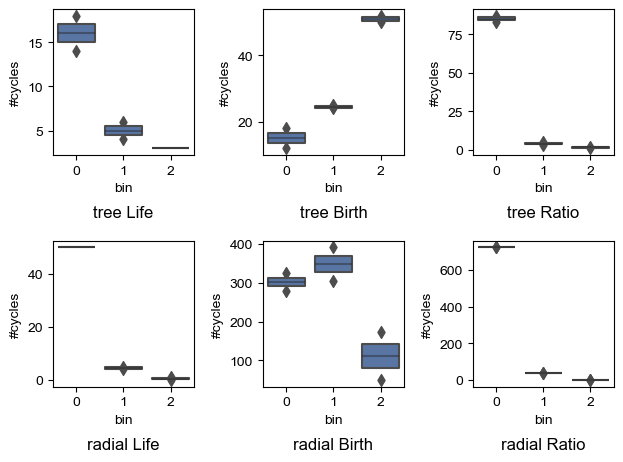

In [6]:
# boxplot
fix,ax = plt.subplots(len(modes),3)
for i,mode in enumerate(modes):
    for j,t in enumerate(['Life','Birth','Ratio']):
        X = results[[f'{mode}_{t}_0',f'{mode}_{t}_1',f'{mode}_{t}_2']].values
        vboxplot(X,ax=ax[i,j],title=f'{mode} {t}')


## Result presentation
Comutation of metrics must be executed first.

In [7]:
## select which subject to look at
idx = 0
metrics = results.iloc[idx]
CTID = metrics['CTID']
H = PHs[CTID]
metrics


CTID              Test01
trachea_z            111
trachea_y            185
trachea_x            174
tree_entropy    4.416845
                  ...   
AC_gen11              12
AC_gen12               2
AC_gen13               4
AC_gen14               6
AC_gen15             6.0
Name: 0, Length: 64, dtype: object

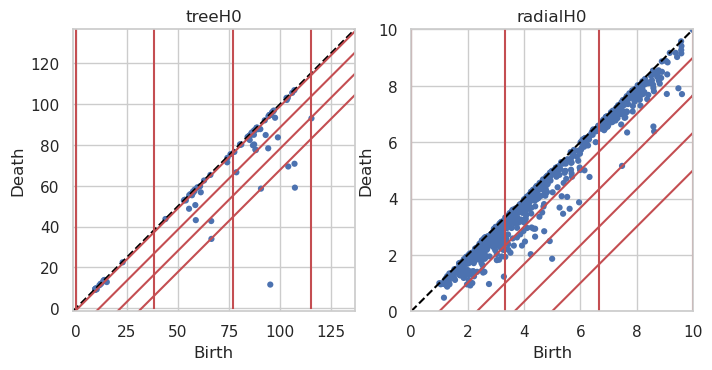

In [8]:
## plot persistence diagram
fig, ax= plt.subplots(1,2,figsize=(8,5))
persim.plot_diagrams(np.abs(H["tree"][:,1:3]),legend=False, lifetime=False, ax=ax[0],title="treeH0")
persim.plot_diagrams(np.abs(H["radial"][:,1:3]),xy_range=(0,max_birth["radial"],0,max_birth["radial"]), legend=False, lifetime=False, ax=ax[1],title="radialH0")
for k,m in enumerate(modes):
    for i in range(num_bins[m]+1):
        ax[k].plot([metrics[f'{m}_Birth_bin{i}'],metrics[f'{m}_Birth_bin{i}']], [0,1000], '-', c="r")
        ax[k].plot([0,1000],[-metrics[f'{m}_Life_bin{i}'],1000-metrics[f'{m}_Life_bin{i}']], '-', c="r")


### Create a volume containing labels for PH cycles

use ITK-snap for visualisation: load the original CT as the main volume and the output of this as segmentation

http://www.itksnap.org/pmwiki/pmwiki.php


In [9]:
## annotation type
annot_type = 'fill' # "fill" or "line"
verbosity = 0 # print information
use_tqdm = False

# load the original volume
volume, header = nrrd.read(input_files[idx], index_order='C')
skeleton_generation,volume_generation,trachea_removed,origin,ac_gens,skeleton_MST = dm.create_generation_volumes(volume,graph_creation="nx",threshold=threshold,min_branch_children=min_branch_children, min_branch_separation=min_branch_separation,remove_trachea=remove_trachea,verbosity=verbosity)
skeleton = (skeleton_generation>0)&(skeleton_generation<=max_gen)
binarised_volume = (volume_generation>0)&(volume_generation<=max_gen)
for annot_metric in ["life","birth","ratio"]:
    for mode in modes:        
        outfn = os.path.join(output_dir,f'{CTID}_{mode}_{annot_metric}_{annot_type}_gen1-{max_gen}.nrrd') # output filename
        annotated = dm.annotated_volume(binarised_volume, skeleton, origin, metrics, H, mode, annot_type, annot_metric, min_life=min_life, max_life=max_life, num_bins=num_bins, verbosity=verbosity, use_tqdm=use_tqdm)
        nrrd.write(outfn, annotated, index_order='C')
        print(f'successfully created {outfn}')

maximum generation 15, #connected components 1, #vertices 324, #edges 323, #leaves 163
successfully created output_5/Test01_tree_life_fill_gen1-5.nrrd
successfully created output_5/Test01_radial_life_fill_gen1-5.nrrd
successfully created output_5/Test01_tree_birth_fill_gen1-5.nrrd
successfully created output_5/Test01_radial_birth_fill_gen1-5.nrrd
successfully created output_5/Test01_tree_ratio_fill_gen1-5.nrrd
successfully created output_5/Test01_radial_ratio_fill_gen1-5.nrrd
